# Stream Data from a .csv 

In [1]:
import sys
import os
import time
import matplotlib.pyplot as plt
# from scipy.signal import butter, filtfilt, lfilter
from scipy import signal
import numpy as np
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler

In [2]:
import sys
sys.path.append("..") # So that it can find the modules
# Assuming the other modules (brainflow_stream, filtering, segmentation, classification) are available
from modules.brainflow_stream import *
from modules.filtering import *
from modules.segmentation import *
from modules.classification import *
from modules.ssvep_stim import *

from modules.visualization import *

<frozen importlib._bootstrap>:219: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.


pygame 2.6.0 (SDL 2.30.7, Python 3.8.20)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
# Setting variables:
board_id = BoardIds.CYTON_BOARD.value # BoardIds.SYNTHETIC_BOARD.value 
frequencies = [9.25, 11.25, 13.25, 15.25]
buttons = ['Right', 'Left', 'Up', 'Down']
button_pos = [0, 2, 3, 1]
display = 0
segment_duration = 3

# Static Variables - Probably don't need to touch :)
harmonics = 3 # np.arange(1, 4) # Generates the 1st, 2nd, & 3rd Harmonics
sampling_rate = BoardShim.get_sampling_rate(board_id)
n_samples = sampling_rate * segment_duration

In [4]:
# Initialize Streaming Board
board = BrainFlowBoardSetup(board_id = BoardIds.PLAYBACK_FILE_BOARD.value,
                            file = '../120s_cyton_recording.csv', # ~120s recording where participant looked at each stimulus for 15 seconds before switching clock-wise to the next
                            master_board = BoardIds.CYTON_BOARD.value )
board.setup()

# board.board_config('/2')

# Let data accumulate
time.sleep(15)

raw_data = board.get_current_board_data(num_samples = n_samples)
eeg_data = raw_data[1:9, :] # Removing the timestamp column
eeg_data.shape
board.stop()

[Board 0, ] Board setup and streaming started successfully.
[Board 0, ] Streaming stopped.
[Board 0, ] Session released.


In [5]:
timestamps = raw_data[22, :]
package_nums = raw_data[0]

In [6]:
filter_obj = Filtering(sampling_rate)

filtered_data = filter_obj.bandpass_filter(eeg_data, highcut=30, lowcut=5, order=8)

channel_names = board.get_eeg_names(board_id=board_id)

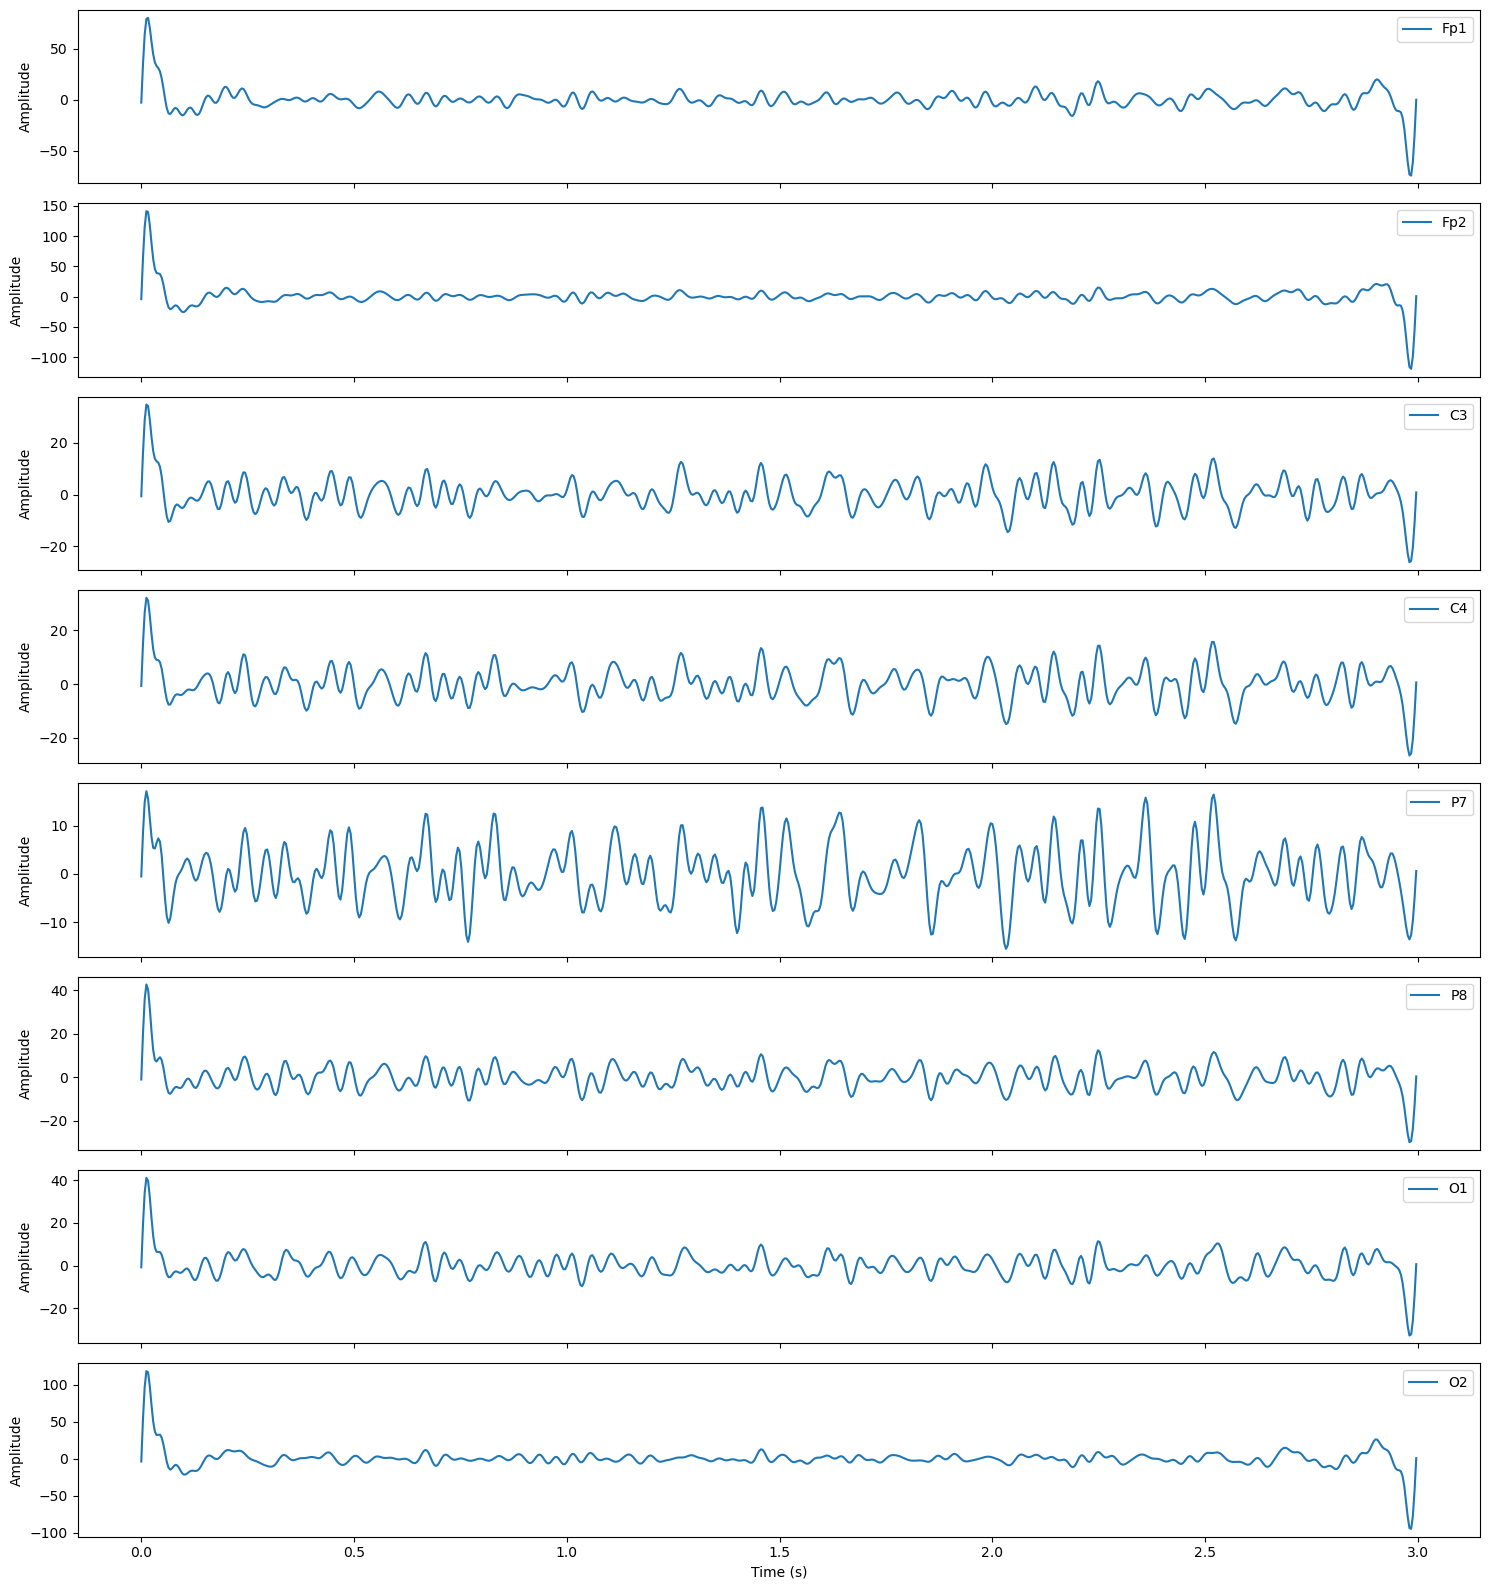

In [7]:
plot_eeg_time_series(filtered_data, sampling_rate, channel_names = channel_names)

c:\Users\surge\miniforge3\envs\stealthneuro\lib\site-packages\scipy\signal\_spectral_py.py:2014: UserWarning: nperseg = 1024 is greater than input length  = 750, using nperseg = 750
  warnings.warn('nperseg = {0:d} is greater than input length '


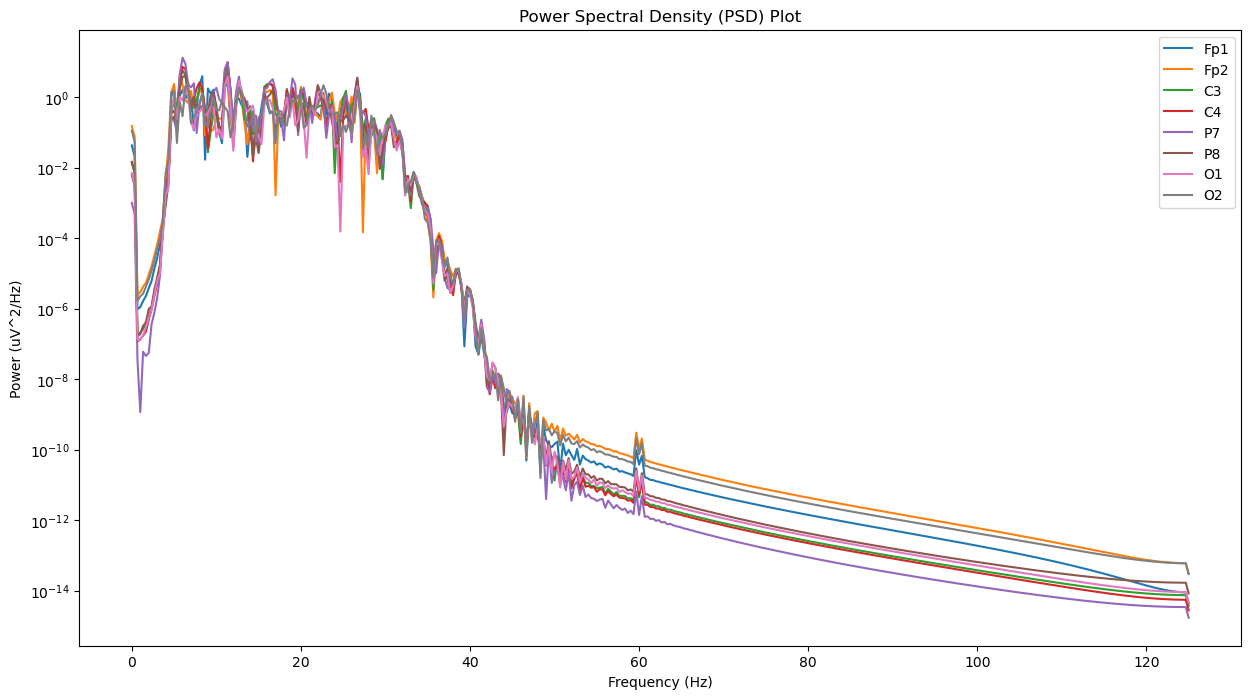

In [8]:
plot_psd(filtered_data, sampling_rate, channel_names = channel_names)

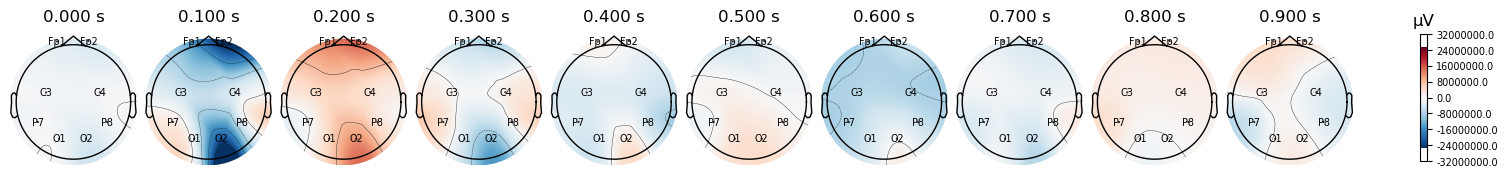

In [9]:
plot_topomap(filtered_data, channel_names = channel_names, sampling_rate=sampling_rate,
             times = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

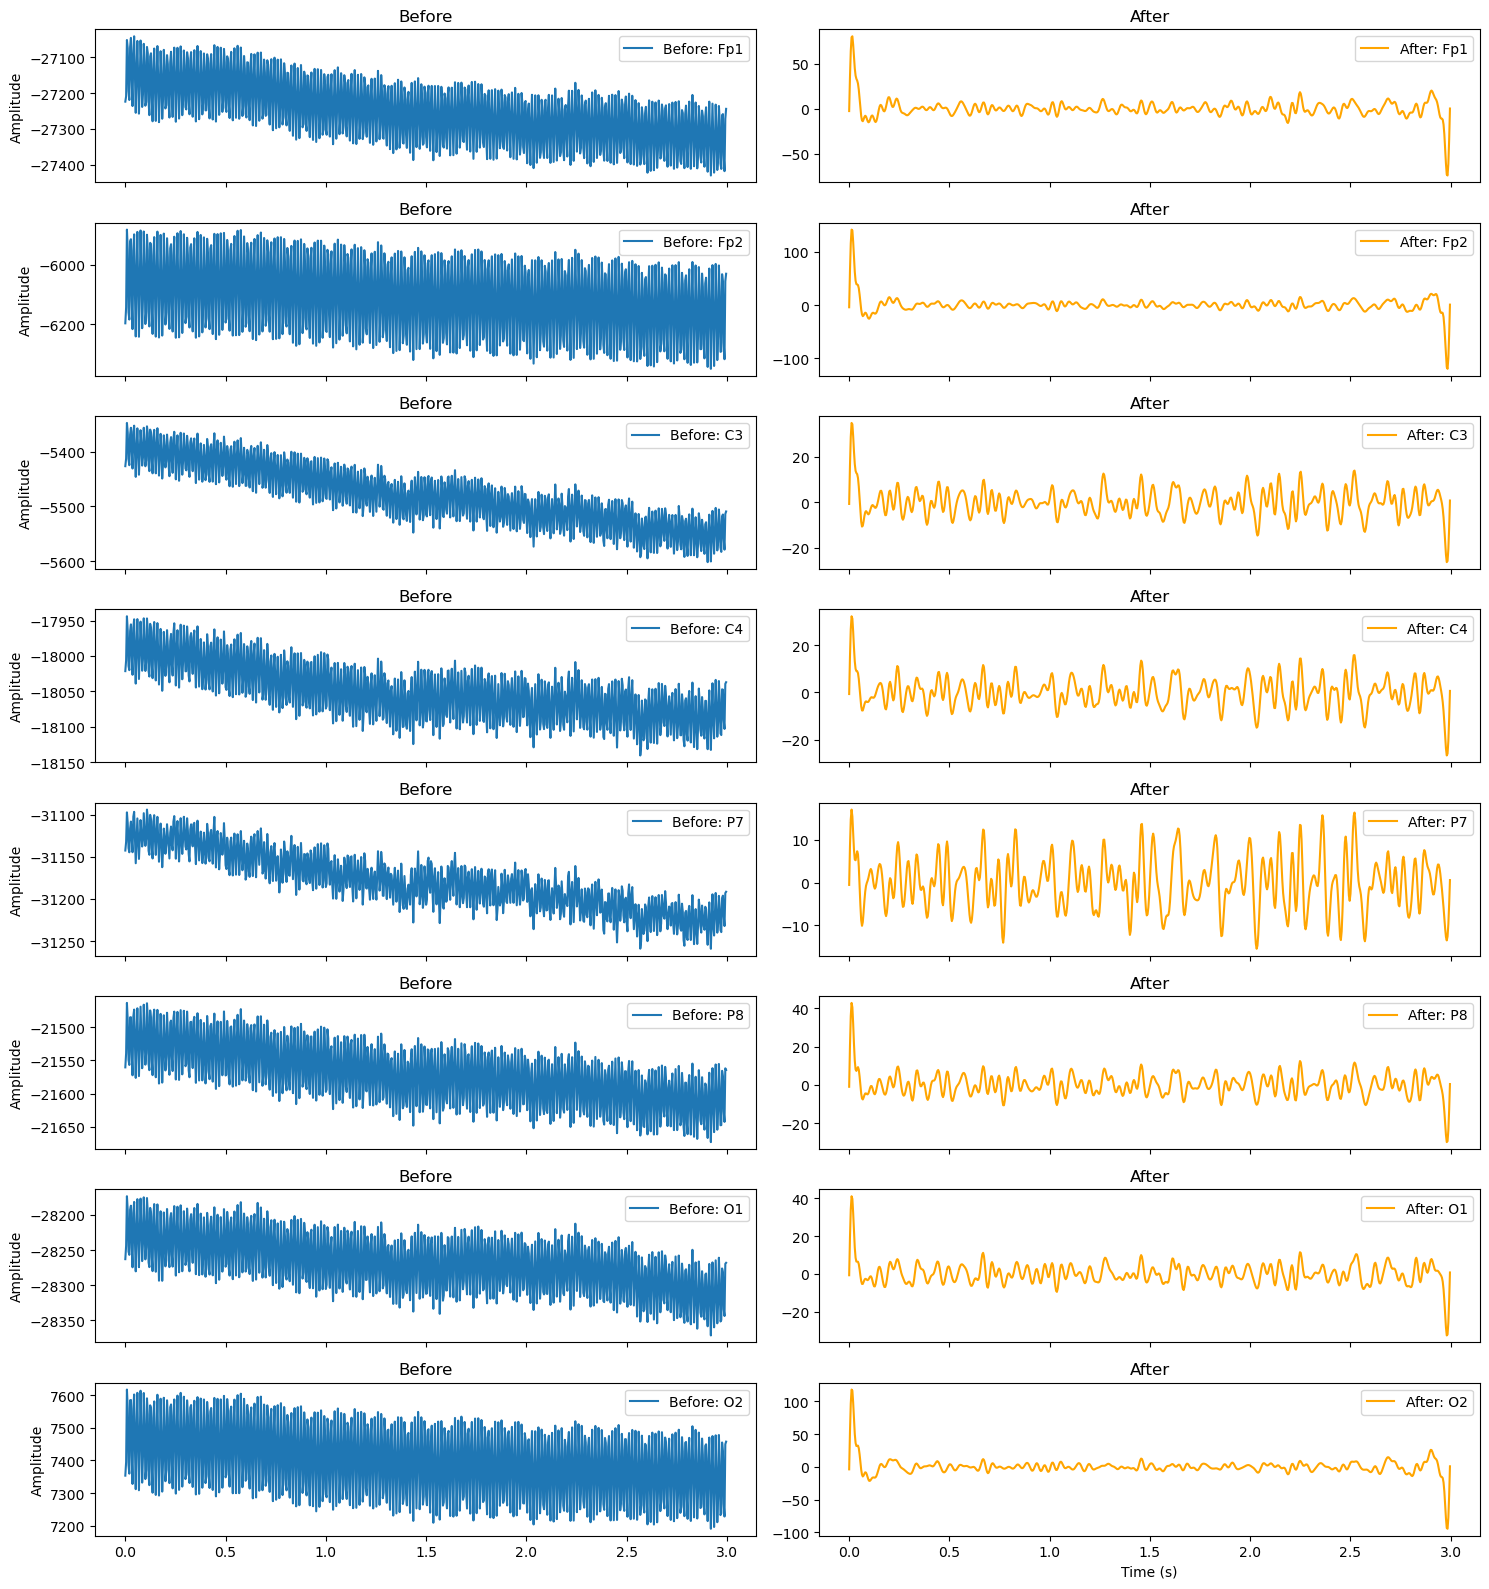

In [10]:
compare_eeg_time_series(eeg_data, filtered_data, sampling_rate, channel_names = channel_names)

c:\Users\surge\miniforge3\envs\stealthneuro\lib\site-packages\scipy\signal\_spectral_py.py:2014: UserWarning: nperseg = 1024 is greater than input length  = 750, using nperseg = 750
  warnings.warn('nperseg = {0:d} is greater than input length '


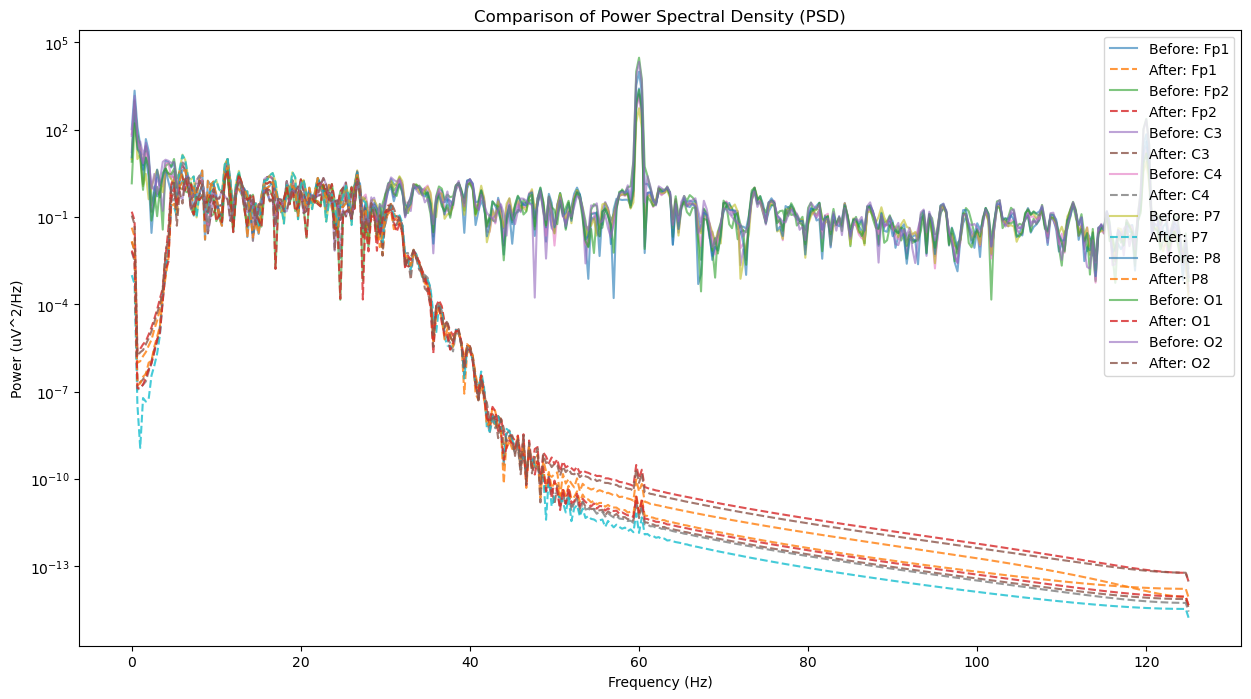

In [11]:
compare_psd(eeg_data, filtered_data, sampling_rate, channel_names = channel_names)

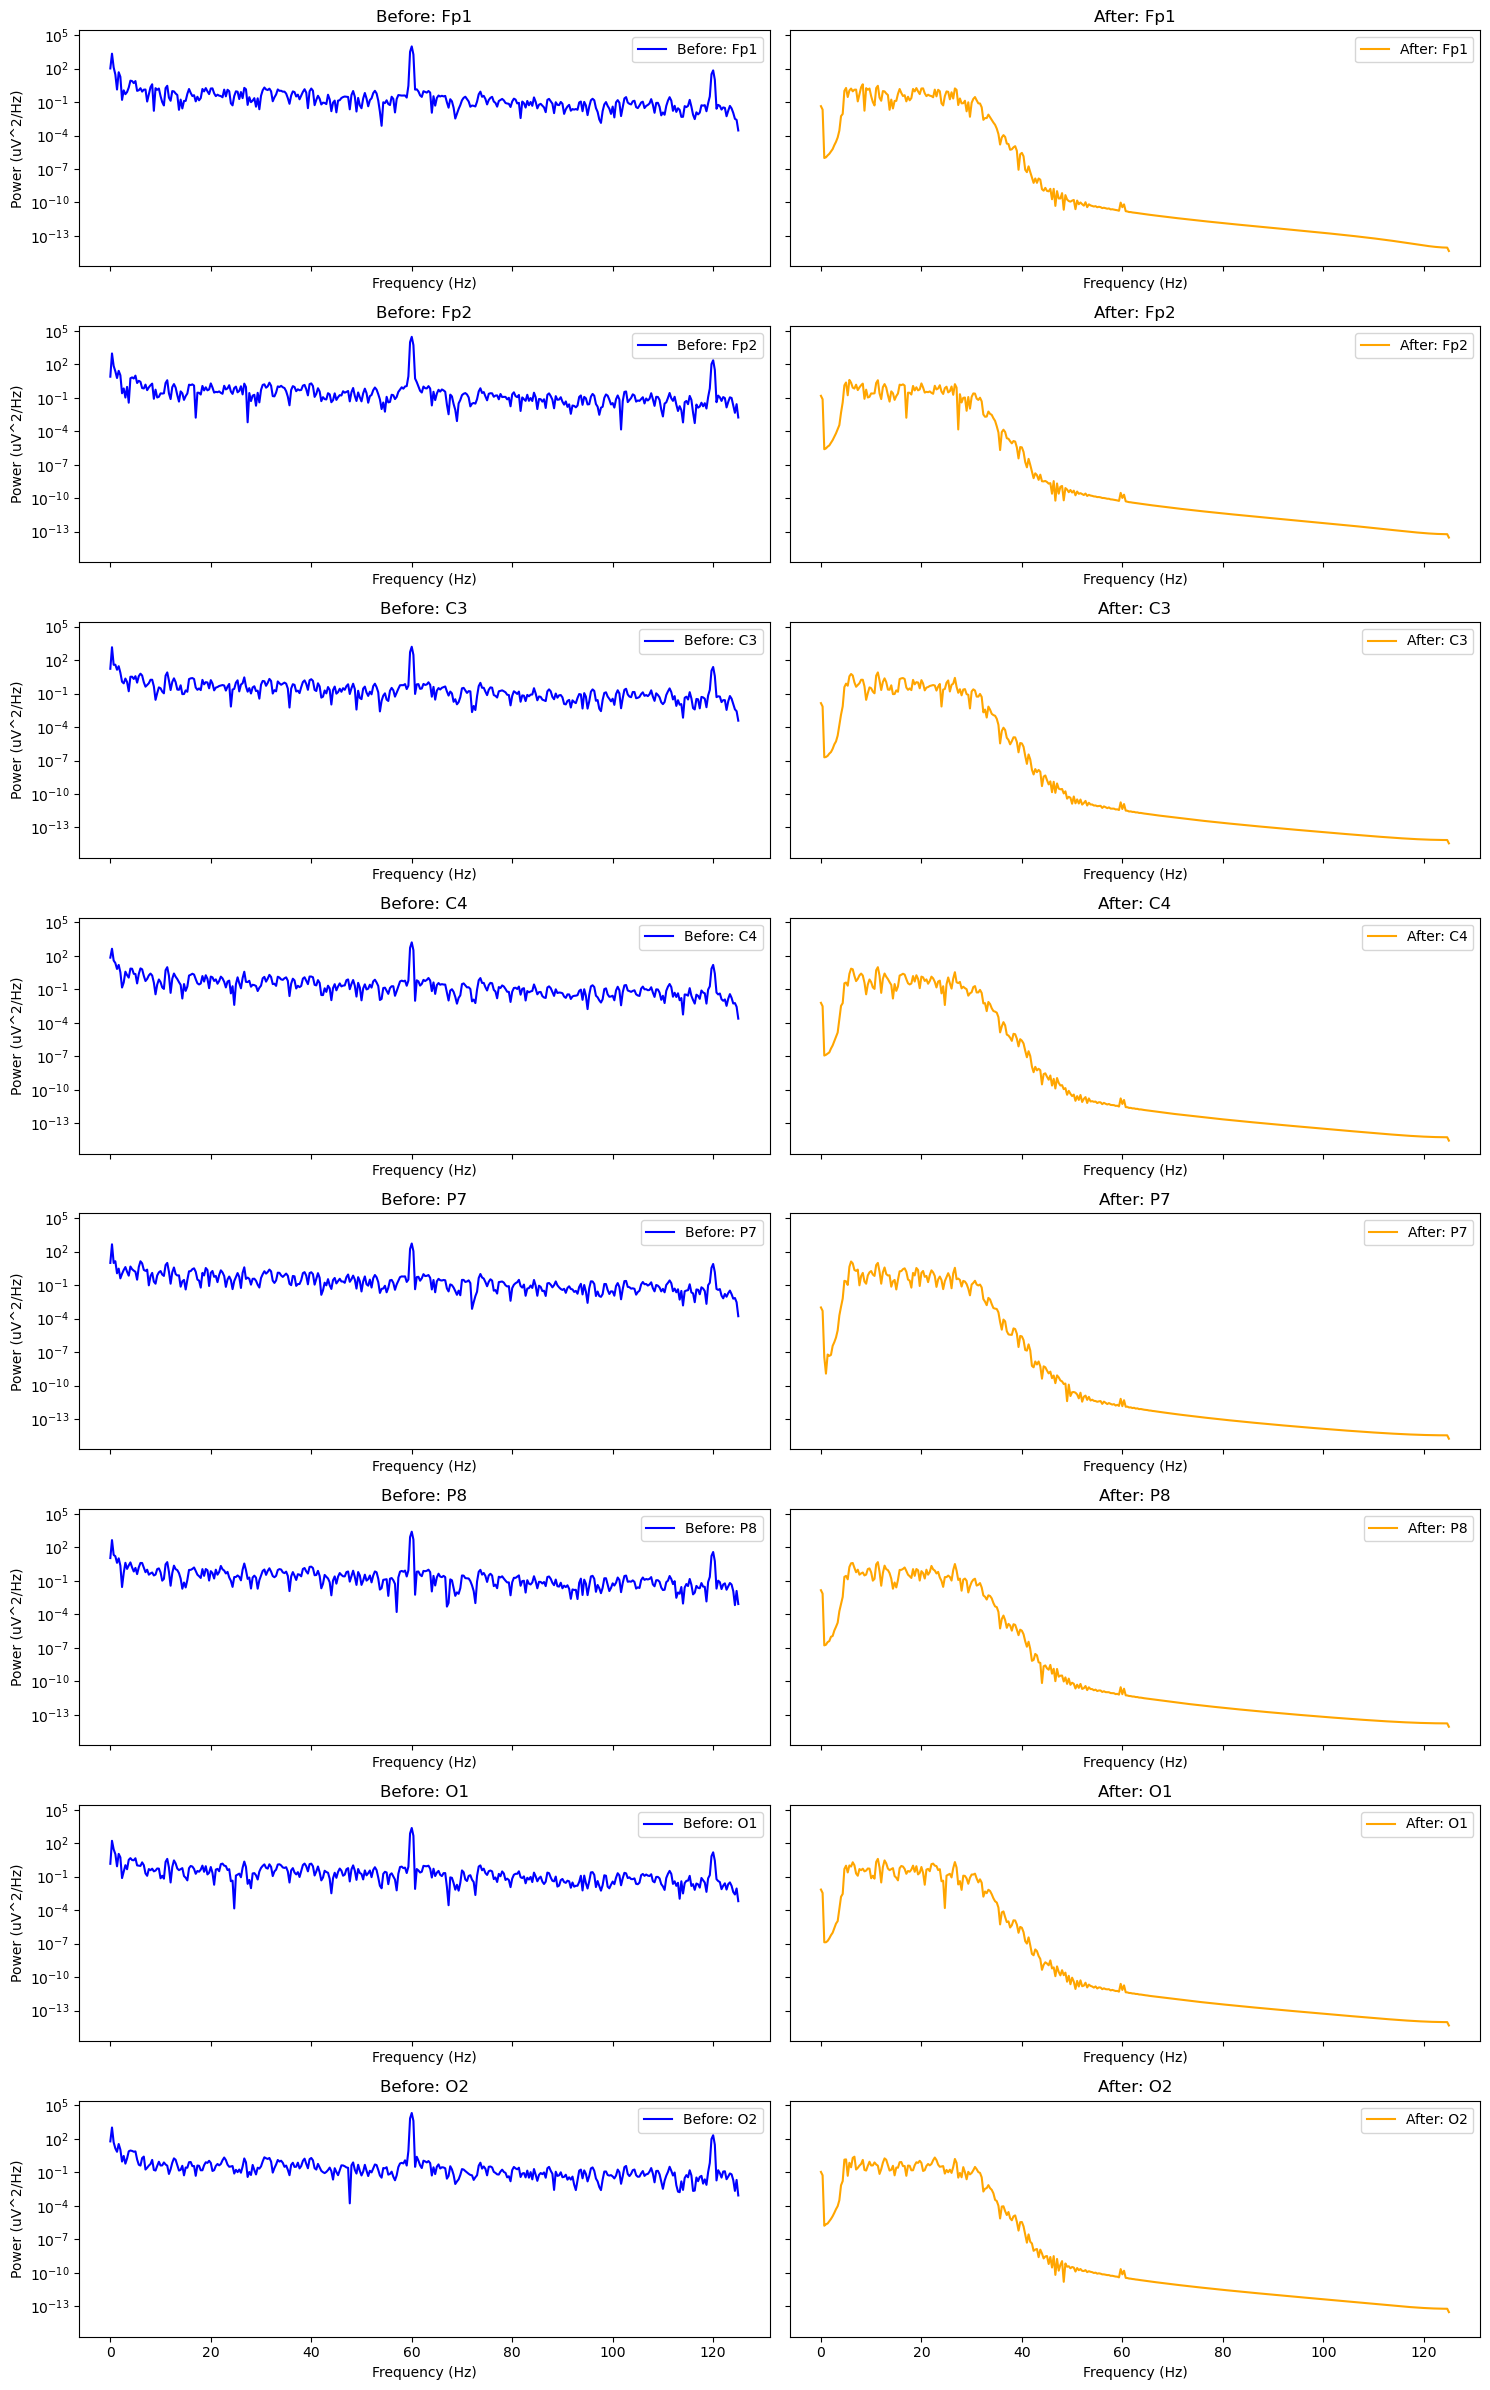

In [12]:
compare_psd_side_by_side(eeg_data, filtered_data, sampling_rate, channel_names = channel_names)

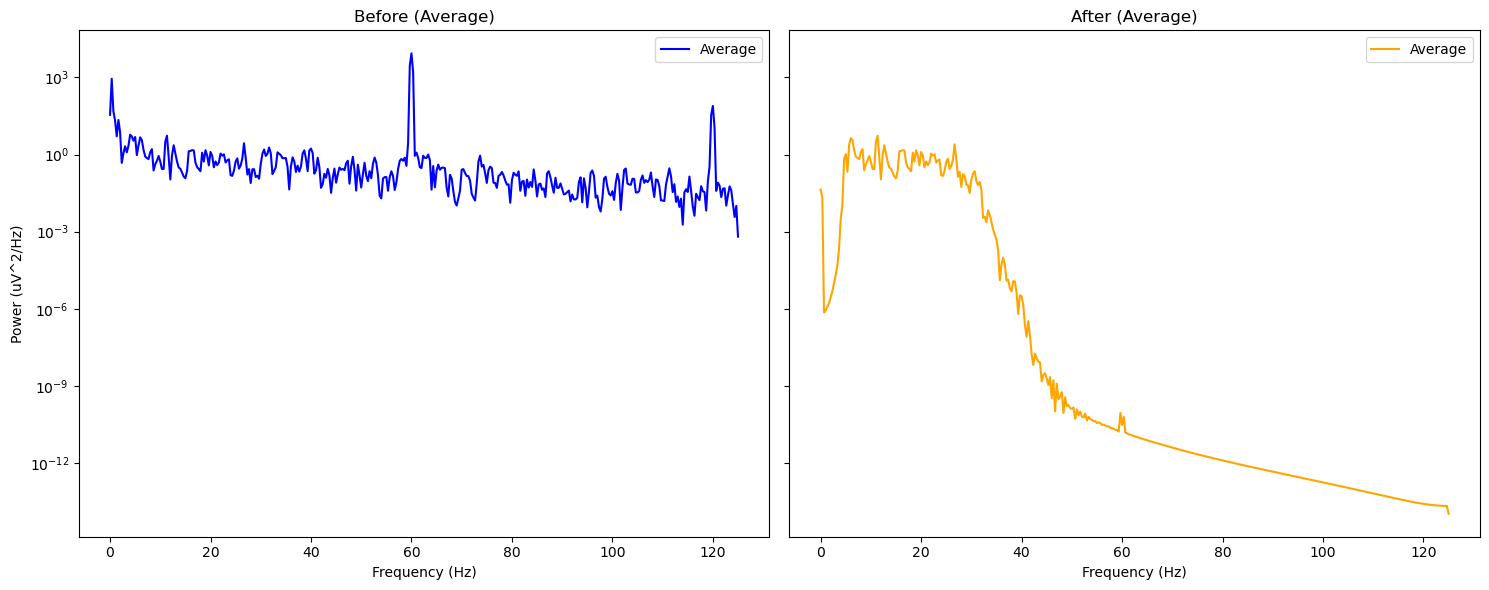

In [13]:
compare_psd_stacked(eeg_data, 
                    filtered_data, 
                    sampling_rate, 
                    channel_names = channel_names,
                    average=True)

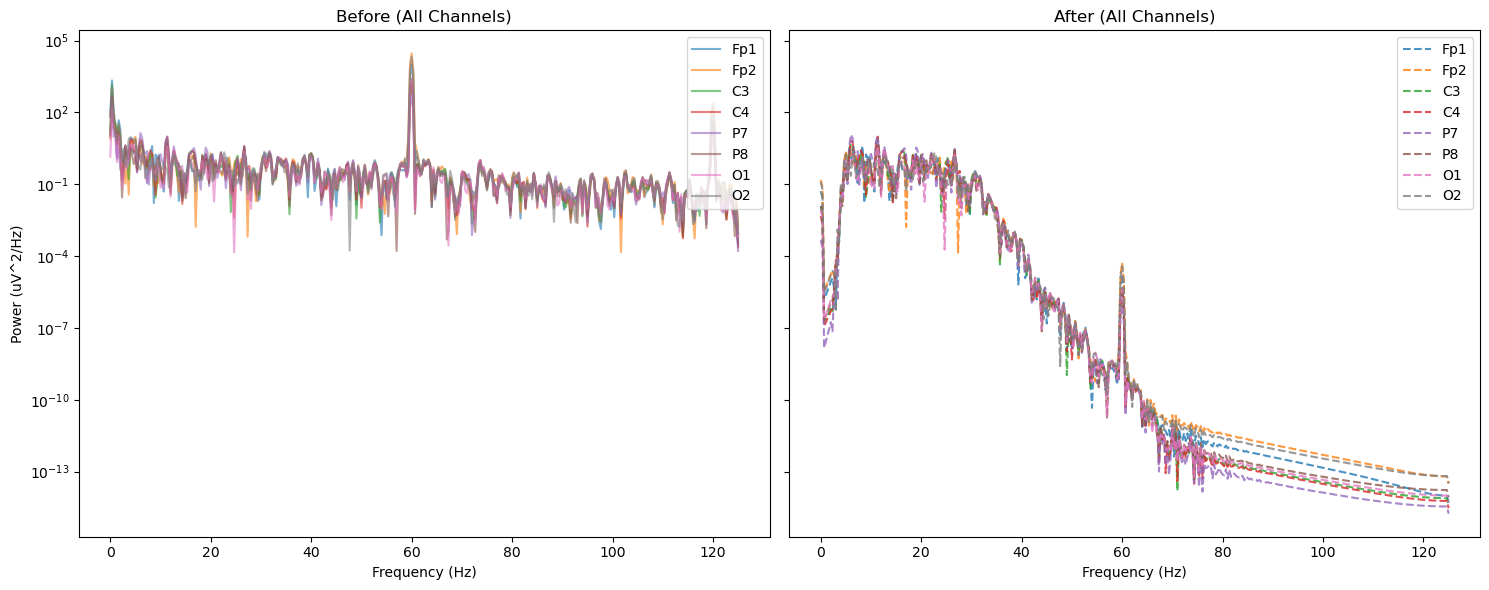

In [14]:
compare_psd_stacked(eeg_data, 
                    filtered_data, 
                    sampling_rate, 
                    channel_names = channel_names,
                    average=False)

c:\Users\surge\Documents\GitHub\BCItoolkit\testing\..\modules\visualization.py:295: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(channel_names, rotation=45, ha='right')
c:\Users\surge\Documents\GitHub\BCItoolkit\testing\..\modules\visualization.py:301: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(channel_names, rotation=45, ha='right')


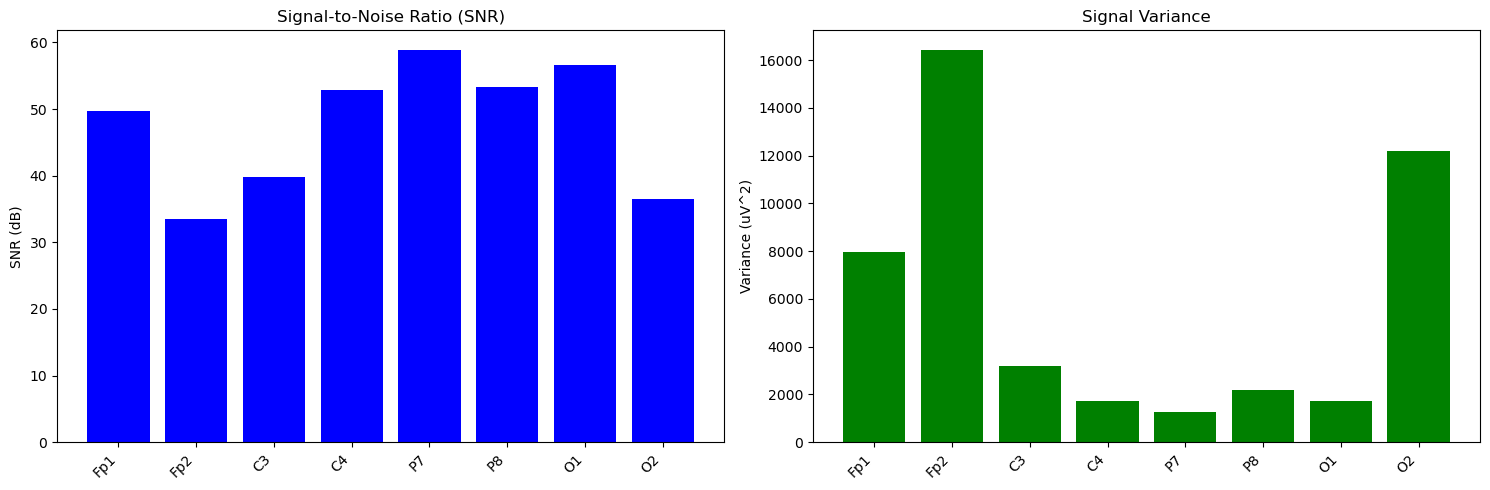

In [14]:
plot_signal_quality(eeg_data, channel_names = channel_names)

## ICA TESTING

In [26]:
import mne
from mne.preprocessing import ICA
import numpy as np


class EEGICAProcessor:
    def __init__(self, raw_eeg_data, sfreq, ch_names):
        """
        Initializes the EEG ICA Processor

        Parameters:
        raw_eeg_data : numpy.ndarray
            The raw EEG data array with shape (n_channels, n_samples).
        sfreq : float
            The sampling frequency of the EEG data.
        ch_names : list
            List of channel names corresponding to the EEG data.
        """
        self.raw_eeg_data = raw_eeg_data
        self.sfreq = sfreq
        self.ch_names = ch_names
        self.raw = None
        self.ica = None

    def preprocess_data(self, low_freq=1.0, high_freq=40.0):
        """
        Preprocess EEG data by applying band-pass filtering.

        Parameters:
        low_freq : float
            The lower frequency bound for filtering.
        high_freq : float
            The upper frequency bound for filtering.
        """
        # Create MNE RawArray object
        info = mne.create_info(ch_names=self.ch_names, sfreq=self.sfreq, ch_types="eeg")
        self.raw = mne.io.RawArray(self.raw_eeg_data, info)

        # Set a standard montage (sensor layout)
        montage = mne.channels.make_standard_montage('standard_1020')
        self.raw.set_montage(montage)

        # Filter the data (band-pass)
        self.raw.filter(l_freq=low_freq, h_freq=high_freq)

    def perform_ica(self, n_components=None, random_state=42):
        """
        Perform ICA on the preprocessed EEG data.

        Parameters:
        n_components : int or None
            Number of components to decompose. If None, the number of channels is used.
        random_state : int
            Random state for reproducibility.
        """
        # Initialize ICA
        self.ica = ICA(n_components=n_components, random_state=random_state)

        # Fit ICA to the raw data
        self.ica.fit(self.raw)

        # Plot ICA components for inspection
        self.ica.plot_components()

    def remove_artifacts(self, exclude_components):
        """
        Remove artifacts by excluding ICA components.

        Parameters:
        exclude_components : list of int
            List of component indices to exclude (remove).
        """
        if self.ica is not None:
            self.ica.exclude = exclude_components
            # Apply ICA cleaning to the raw data
            self.raw = self.ica.apply(self.raw)
        else:
            raise RuntimeError("ICA has not been performed yet.")

    def get_cleaned_data(self):
        """
        Return the cleaned EEG data after ICA artifact removal.

        Returns:
        cleaned_data : numpy.ndarray
            The cleaned EEG data array.
        """
        if self.raw is not None:
            return self.raw.get_data()
        else:
            raise RuntimeError("Raw data has not been preprocessed or ICA has not been applied.")


Creating RawArray with float64 data, n_channels=8, n_times=750
    Range : 0 ... 749 =      0.000 ...     2.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 s)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 4 components
Fitting ICA took 0.0s.


C:\Users\surge\AppData\Local\Temp\ipykernel_26184\716410419.py:44: RuntimeWarning: filter_length (825) is longer than the signal (750), distortion is likely. Reduce filter length or filter a longer signal.
  self.raw.filter(l_freq=low_freq, h_freq=high_freq)


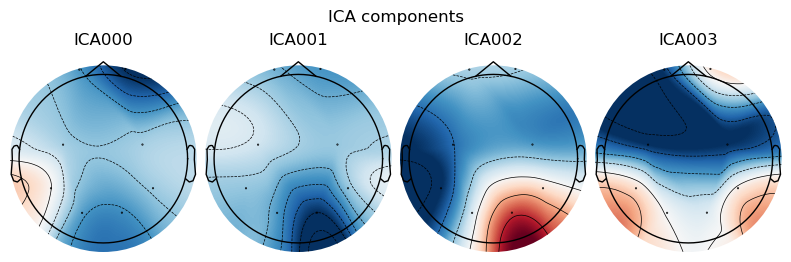

Applying ICA to Raw instance
    Transforming to ICA space (4 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


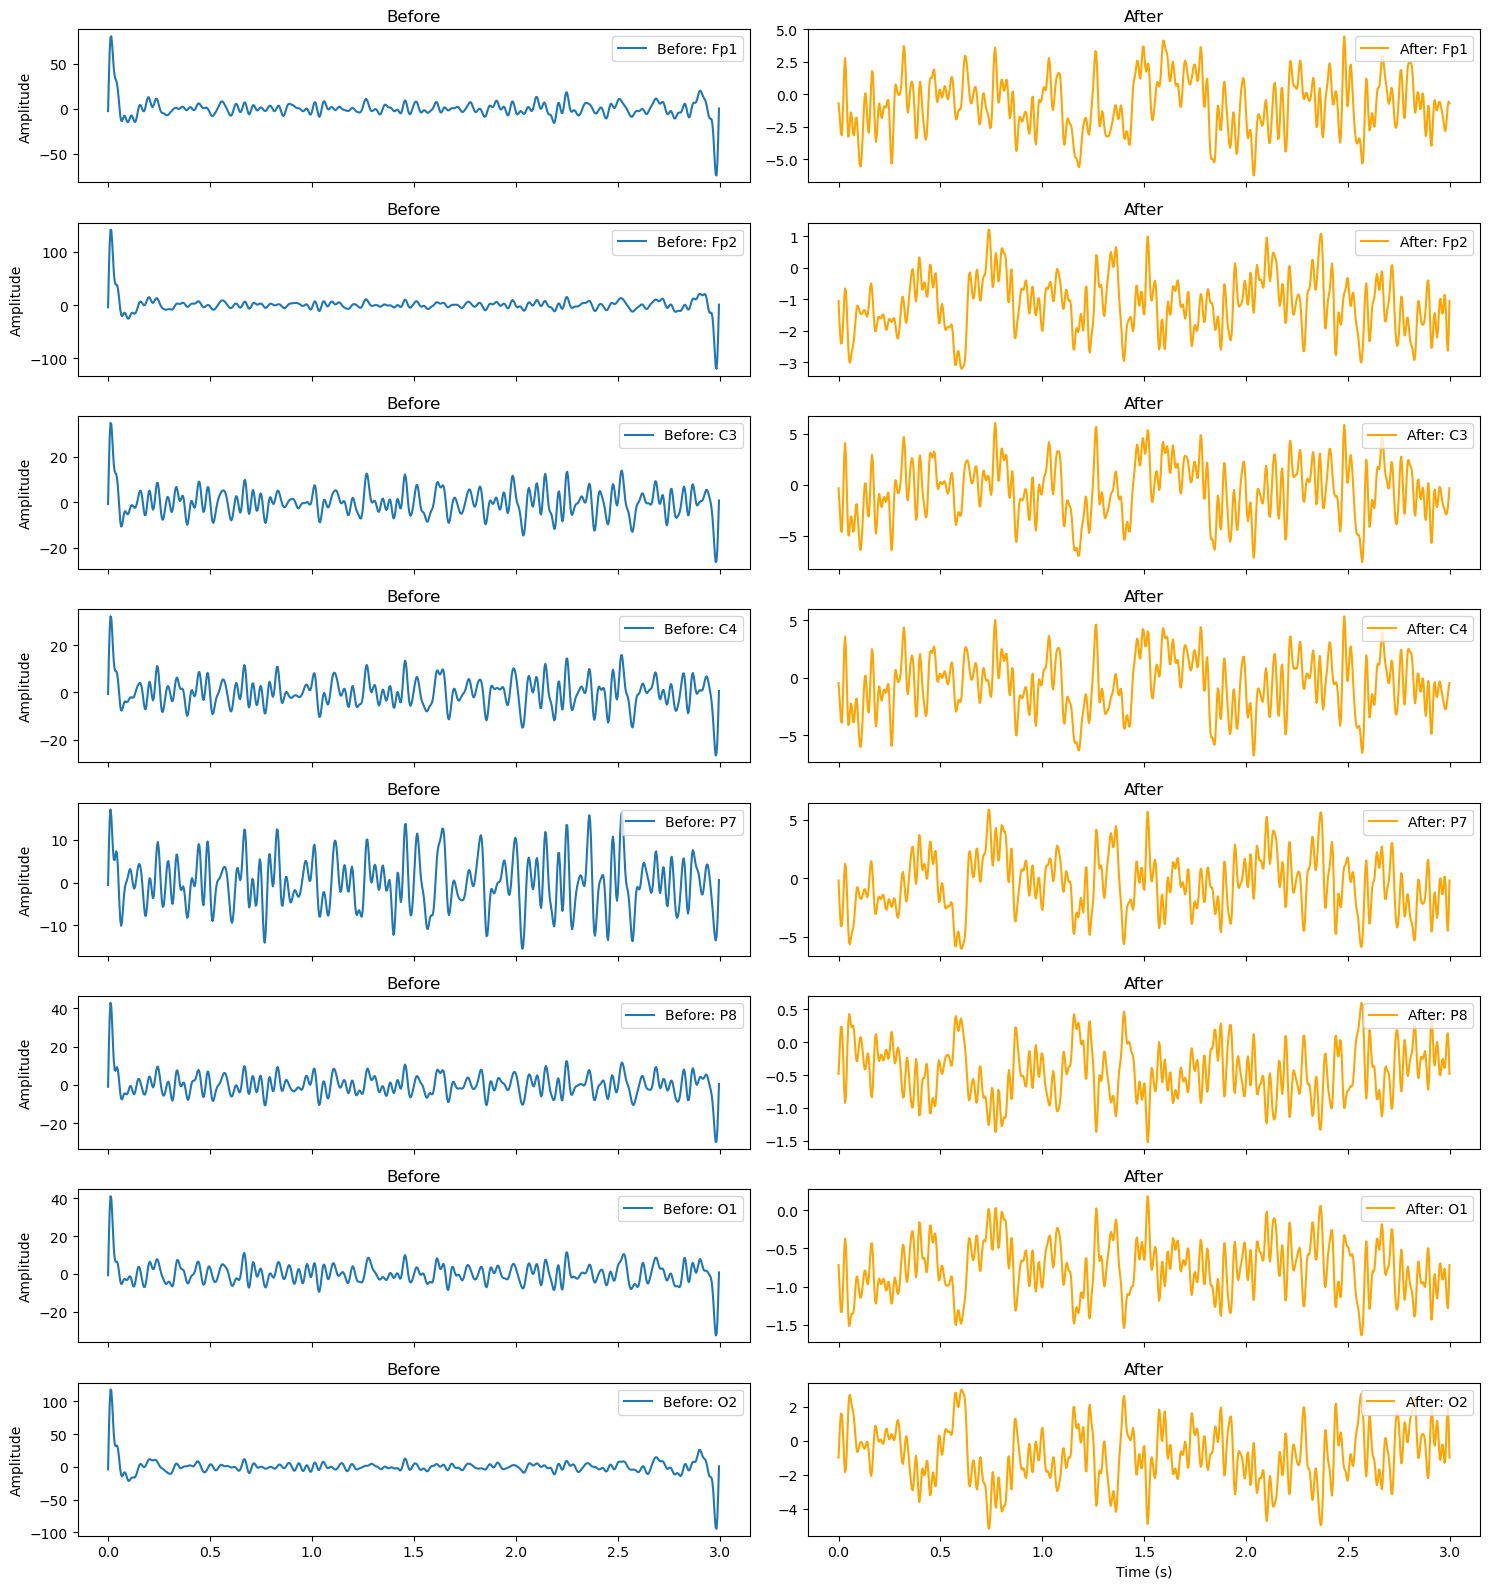

In [27]:
ica_processor = EEGICAProcessor(eeg_data, sampling_rate, channel_names)

# Preprocess the data (band-pass filter and set montage)
ica_processor.preprocess_data()

# Perform ICA
ica_processor.perform_ica()

# Exclude components based on visual inspection (e.g., artifacts)
ica_processor.remove_artifacts(exclude_components=[0, 1])

# Get the cleaned data
cleaned_data = ica_processor.get_cleaned_data()
# print(cleaned_data)
compare_eeg_time_series(filtered_data, cleaned_data, sampling_rate, channel_names = channel_names)

## FASTICA TESTING

In [33]:
from sklearn.decomposition import FastICA
import numpy as np
import mne

class EEGFastICAProcessor:
    def __init__(self, raw_eeg_data, sfreq, ch_names):
        """
        Initializes the EEG FastICA Processor.

        Parameters:
        raw_eeg_data : numpy.ndarray
            The raw EEG data array with shape (n_channels, n_samples).
        sfreq : float
            The sampling frequency of the EEG data.
        ch_names : list
            List of channel names corresponding to the EEG data.
        """
        self.raw_eeg_data = raw_eeg_data
        self.sfreq = sfreq
        self.ch_names = ch_names
        self.filtered_data = None
        self.fastica = None
        self.components_ = None

    def preprocess_data(self, low_freq=1.0, high_freq=40.0):
        """
        Preprocess EEG data by applying band-pass filtering.

        Parameters:
        low_freq : float
            The lower frequency bound for filtering.
        high_freq : float
            The upper frequency bound for filtering.
        """
        # Create MNE RawArray object
        info = mne.create_info(ch_names=self.ch_names, sfreq=self.sfreq, ch_types="eeg")
        raw = mne.io.RawArray(self.raw_eeg_data, info)

        # Set a standard montage (sensor layout)
        montage = mne.channels.make_standard_montage('standard_1020')
        raw.set_montage(montage)

        # Filter the data (band-pass)
        raw.filter(l_freq=low_freq, h_freq=high_freq)

        # Get the filtered data
        self.filtered_data = raw.get_data()

    def perform_fastica(self, n_components=None, random_state=42):
        """
        Perform FastICA on the preprocessed EEG data.

        Parameters:
        n_components : int or None
            Number of components to decompose. If None, the number of channels is used.
        random_state : int
            Random state for reproducibility.
        """
        if self.filtered_data is None:
            raise RuntimeError("Data has not been preprocessed yet.")
        
        # Initialize FastICA
        self.fastica = FastICA(n_components=n_components, random_state=random_state)

        # Apply FastICA to the filtered EEG data
        self.components_ = self.fastica.fit_transform(self.filtered_data.T)  # Transpose to (n_samples, n_channels)

        # Transpose components back to (n_channels, n_samples)
        self.components_ = self.components_.T

    def remove_artifacts(self, exclude_components):
        """
        Reconstruct the EEG data after excluding specified ICA components.

        Parameters:
        exclude_components : list of int
            List of component indices to exclude (remove).
        """
        if self.components_ is None:
            raise RuntimeError("FastICA has not been performed yet.")

        # Reconstruct the EEG data by zeroing out excluded components
        reconstructed = self.components_.copy()
        reconstructed[exclude_components, :] = 0

        # Inverse transform to get the cleaned EEG data
        cleaned_data = self.fastica.inverse_transform(reconstructed.T).T

        return cleaned_data

    def get_cleaned_data(self, exclude_components=[]):
        """
        Return the cleaned EEG data after excluding specified ICA components.

        Parameters:
        exclude_components : list of int
            List of component indices to exclude (remove).

        Returns:
        cleaned_data : numpy.ndarray
            The cleaned EEG data array.
        """
        return self.remove_artifacts(exclude_components)


Creating RawArray with float64 data, n_channels=8, n_times=750
    Range : 0 ... 749 =      0.000 ...     2.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 s)



C:\Users\surge\AppData\Local\Temp\ipykernel_26184\60499822.py:44: RuntimeWarning: filter_length (825) is longer than the signal (750), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(l_freq=low_freq, h_freq=high_freq)
c:\Users\surge\miniforge3\envs\stealthneuro\lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


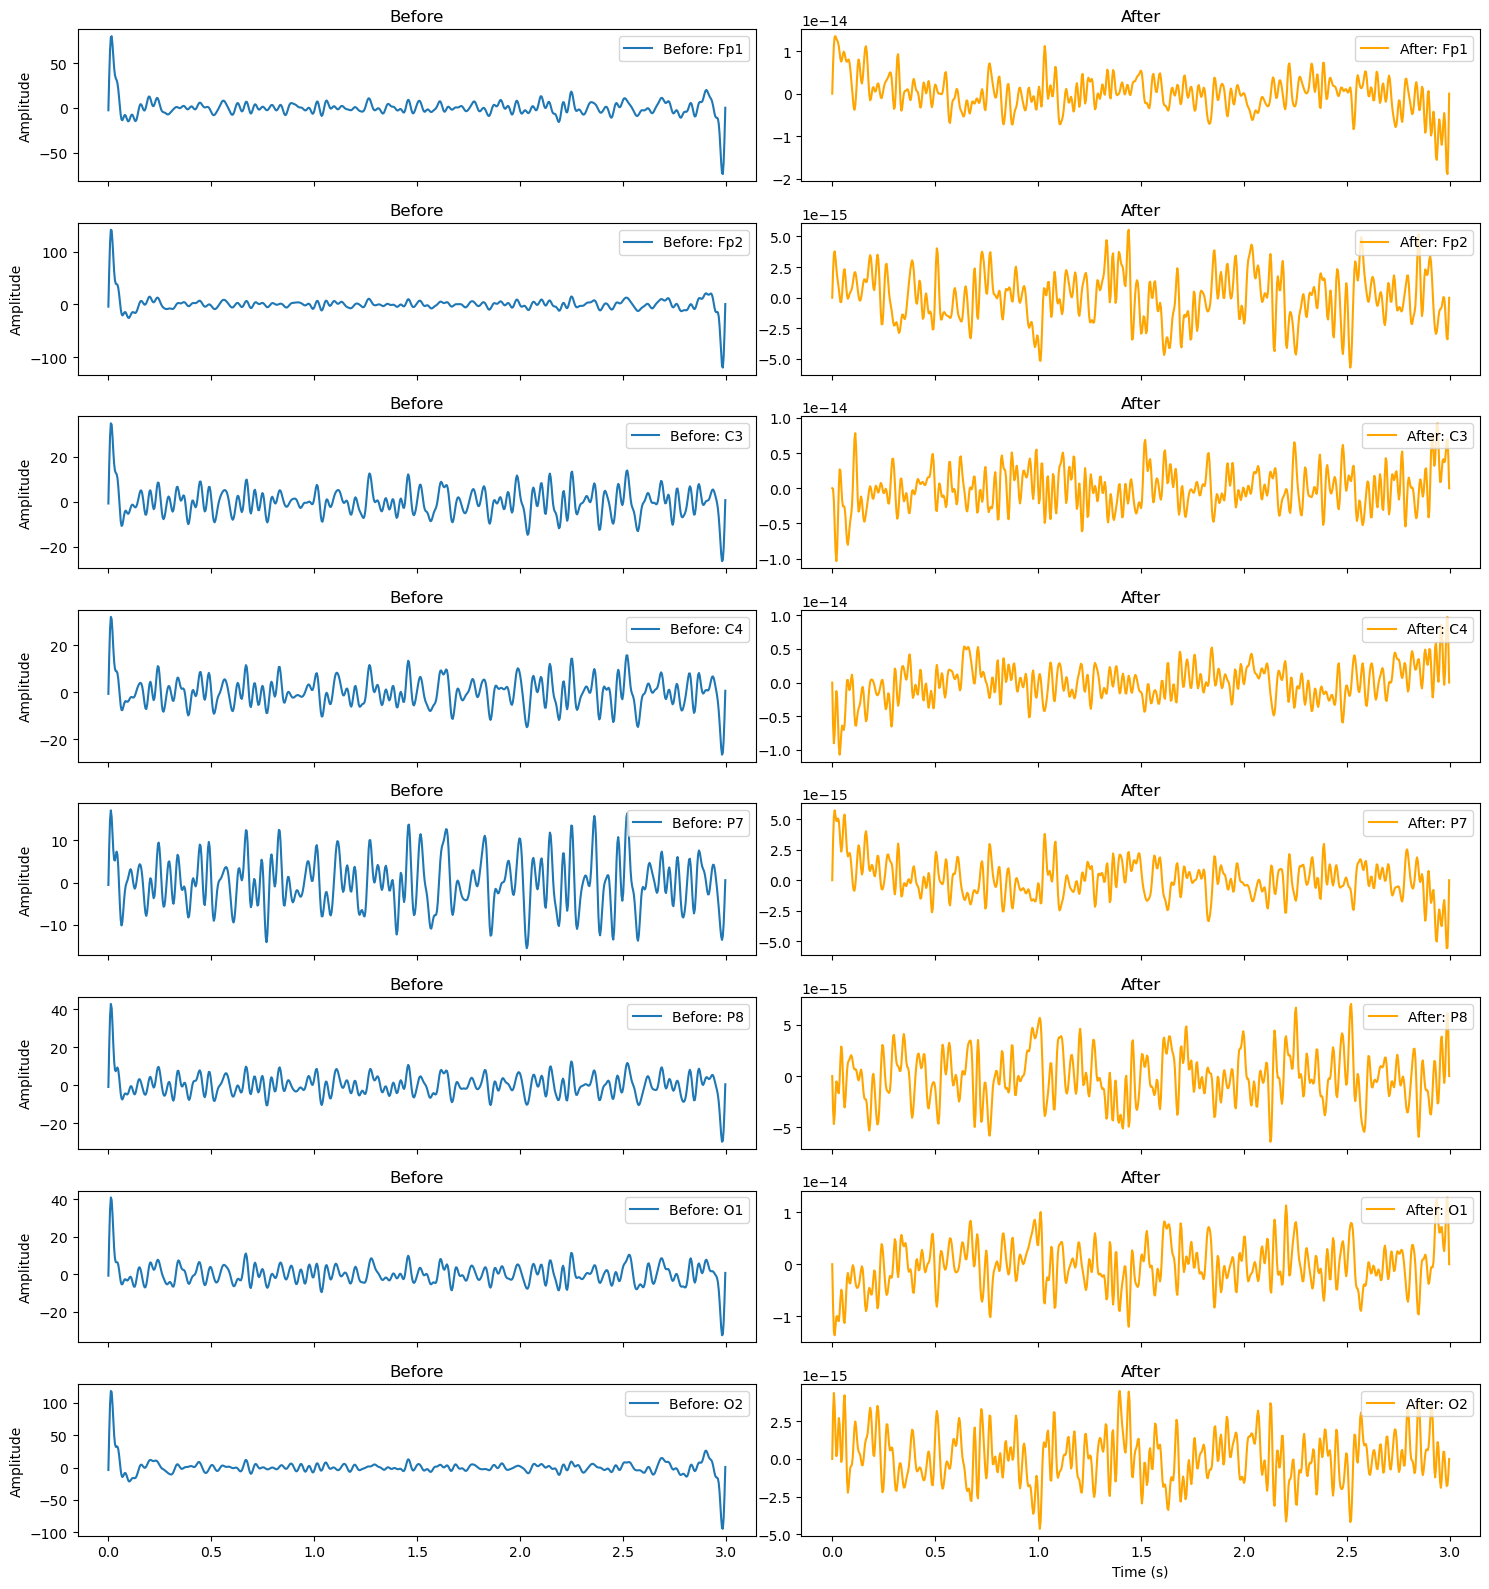

In [34]:
ica_processor = EEGFastICAProcessor(eeg_data, sampling_rate, channel_names)

# Preprocess the data (band-pass filter and set montage)
ica_processor.preprocess_data()

# Perform ICA
ica_processor.perform_fastica()

# Exclude components based on visual inspection (e.g., artifacts)
ica_processor.remove_artifacts(exclude_components=[0, 1])

# Get the cleaned data
cleaned_data = ica_processor.get_cleaned_data()
# print(cleaned_data)

compare_eeg_time_series(filtered_data, cleaned_data, sampling_rate, channel_names = channel_names)

In [8]:
board.stop()

: 

### Reference code from `Pipeline_Test_Suite_STREAM_DATA.py`

In [ ]:
# Initialize Streaming Board
board = BrainFlowBoardSetup(board_id = BoardIds.PLAYBACK_FILE_BOARD.value,
                            file = '120s_cyton_recording.csv', # ~120s recording where participant looked at each stimulus for 15 seconds before switching clock-wise to the next
                            master_board = BoardIds.CYTON_BOARD.value )
board.setup()

actual_freqs = [9.23, 11.43, 13.33, 15.0] # Actual stim freqs when recording the data
print("Actual Frequencies:", actual_freqs)

# cca_classifier = SSVEPClassifier(frequencies=actual_freqs, 
#                                 harmonics=harmonics, 
#                                 sampling_rate=sampling_rate, 
#                                 n_samples=n_samples, 
#                                 method='CCA', 
#                                 stack_harmonics=True)

cca_classifier = SSVEPClassifier(freqs=actual_freqs, 
                                win_len=segment_duration, 
                                s_rate=sampling_rate)

filter_obj = Filtering(sampling_rate)

time.sleep(15)

while True:
    segment = board.get_current_board_data(num_samples=n_samples)
    eeg_segment = segment[1:9, :]  # Channels 1-9 are EEG channels
    
    dc_offset_removed = remove_dc_offset(eeg_segment)
            
    # Apply bandpass filter
    filtered_segment = filter_obj.bandpass_filter(dc_offset_removed, highcut=30, lowcut=0.1, order=4)

    r = cca_classifier.apply_cca(filtered_segment.T) 
    print(r)
    
    # visualize_all_channels_plotly(eeg_segment, filtered_segment)
    
    # Check signal alignment for the first frequency
    # reference_signal = cca_classifier.reference_signals[0]  # First frequency reference
    # check_signal_alignment(filtered_segment, reference_signal)

    # Compare one EEG channel (Channel 1) against reference signal for the first frequency
    # visualize_reference_vs_eeg(filtered_segment, reference_signal, actual_freqs[0])
    
    

    # Perform classification using the filtered EEG data
    # correlations = []
    # for freq_idx, freq in enumerate(actual_freqs):
    #     detected_freq, correlation = cca_classifier(filtered_segment)
    #     correlations.append(correlation)
    #     print(f"Frequency: {freq} Hz, Correlation: {correlation}")

    # Plot correlation coefficients across frequencies (optional, uncomment if needed)
    # plot_correlation_across_frequencies(actual_freqs, correlations)
    


    # Wait for the next segment of data
    time.sleep(segment_duration)